<a href="https://colab.research.google.com/github/xdomodomox/colab/blob/main/RNN%E9%A1%9E%E5%88%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from tensorflow import keras
from tensorflow.keras import backend as clear
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

# Functions for evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from imblearn.metrics import sensitivity_score
from imblearn.metrics import specificity_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

In [ ]:
# 讀取股票數據
data = pd.read_csv('/content/drive/MyDrive/ANN_Timeseries_Forecast_python_demo/Data/Close.csv')

# 提取 Close 數據
close_data = data['Close'].values.reshape(-1, 1)

# 計算漲跌幅度
price_diff = np.diff(close_data, axis=0)
price_diff = np.where(price_diff > 0, 1, 0)

close_data

array([[550.      ],
       [539.215698],
       [547.058838],
       ...,
       [740.      ],
       [734.      ],
       [746.      ]])

In [ ]:
split =int(0.8*close_data.shape[0])
Train,Test  = close_data[0:split] , close_data[split:]

val_split=int(0.8*len(Train))
Train,Val=Train[0:val_split] , Train[val_split:1341+447]
#Val=Val.reset_index(drop=True)
#Test=Test.reset_index(drop=True)
Train

array([[550.      ],
       [539.215698],
       [547.058838],
       ...,
       [216.5     ],
       [216.5     ],
       [218.      ]])

In [ ]:
sc = MinMaxScaler(feature_range = (0, 1))
#需將資料做reshape的動作，使其shape為(資料長度,1)
#train_set= Train.values.reshape(-1,1)
training_set_scaled = sc.fit_transform(Train)
#val_set= Val.values.reshape(-1,1)
val_set_scaled = sc.transform(Val)
#test_set = Test.values.reshape(-1,1)
test_set_scaled = sc.transform(Test)

training_set_scaled

array([[0.93592367],
       [0.90773014],
       [0.92823455],
       ...,
       [0.06405064],
       [0.06405064],
       [0.06797211]])

In [ ]:


X_train = []
y_train = []
for i in range(len(Train)-5):
    X_train.append(training_set_scaled[i:(i+5),0])
    y_train.append(price_diff[i+5])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1], 1))

X_val = []
y_val = []
for i in range(len(Val)-5):
    X_val.append(val_set_scaled[i:(i+5),0])
    y_val.append(price_diff[i+5])
X_val, y_val = np.array(X_val), np.array(y_val)
X_val = np.reshape(X_val,(X_val.shape[0], X_val.shape[1], 1))

X_test = []
y_test = []
for i in range(len(Test)-5):
    X_test.append(test_set_scaled[i:(i+5),0])
    y_test.append(price_diff[i+5])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))

In [ ]:
keras.backend.clear_session()
model = keras.models.Sequential([
    GRU(32, input_shape=(X_train.shape[1], 1)),
    Dense(1)
])
opt=Adam(learning_rate=0.001,beta_1=0.95)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                3360      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


In [ ]:
keras.backend.clear_session()
# 建立 RNN 模型
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=32))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model.summary()

# 編譯模型
opt=Adam(learning_rate=0.001,beta_1=0.95)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 64)             16896     
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 訓練模型
history = model.fit(X_train, y_train, epochs=100, batch_size=32,verbose=1,validation_data=(X_val,y_val))


Epoch 1/100
54/54 [==============================] - 3s 14ms/step - loss: 1.1505 - accuracy: 0.5395 - val_loss: 1.1553 - val_accuracy: 0.5075
Epoch 2/100
54/54 [==============================] - 0s 5ms/step - loss: 0.9068 - accuracy: 0.5395 - val_loss: 1.0780 - val_accuracy: 0.5075
Epoch 3/100
54/54 [==============================] - 0s 5ms/step - loss: 0.8564 - accuracy: 0.5395 - val_loss: 1.0189 - val_accuracy: 0.5075
Epoch 4/100
54/54 [==============================] - 0s 6ms/step - loss: 0.8124 - accuracy: 0.5395 - val_loss: 0.9583 - val_accuracy: 0.5075
Epoch 5/100
54/54 [==============================] - 0s 5ms/step - loss: 0.7736 - accuracy: 0.5395 - val_loss: 0.8921 - val_accuracy: 0.5075
Epoch 6/100
54/54 [==============================] - 0s 5ms/step - loss: 0.7416 - accuracy: 0.5248 - val_loss: 0.8422 - val_accuracy: 0.5075
Epoch 7/100
54/54 [==============================] - 0s 5ms/step - loss: 0.7275 - accuracy: 0.5091 - val_loss: 0.8066 - val_accuracy: 0.5075
Epoch 8/100


In [ ]:
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
mean=np.mean(modeling_result['loss'])
std=np.std(modeling_result['loss'])
v_mean=np.mean(modeling_result['val_loss'])
v_std=np.std(modeling_result['val_loss'])
print('Loss\n平均：'+ str(mean) +'\n標準差：'+ str(std) + '\nval_Loss\n平均：'+str(v_mean)+'\n標準差：'+str(v_std))

Loss
平均：0.7040429300069809
標準差：0.05458600952042945
val_Loss
平均：0.7191228091716766
標準差：0.07665260937267088


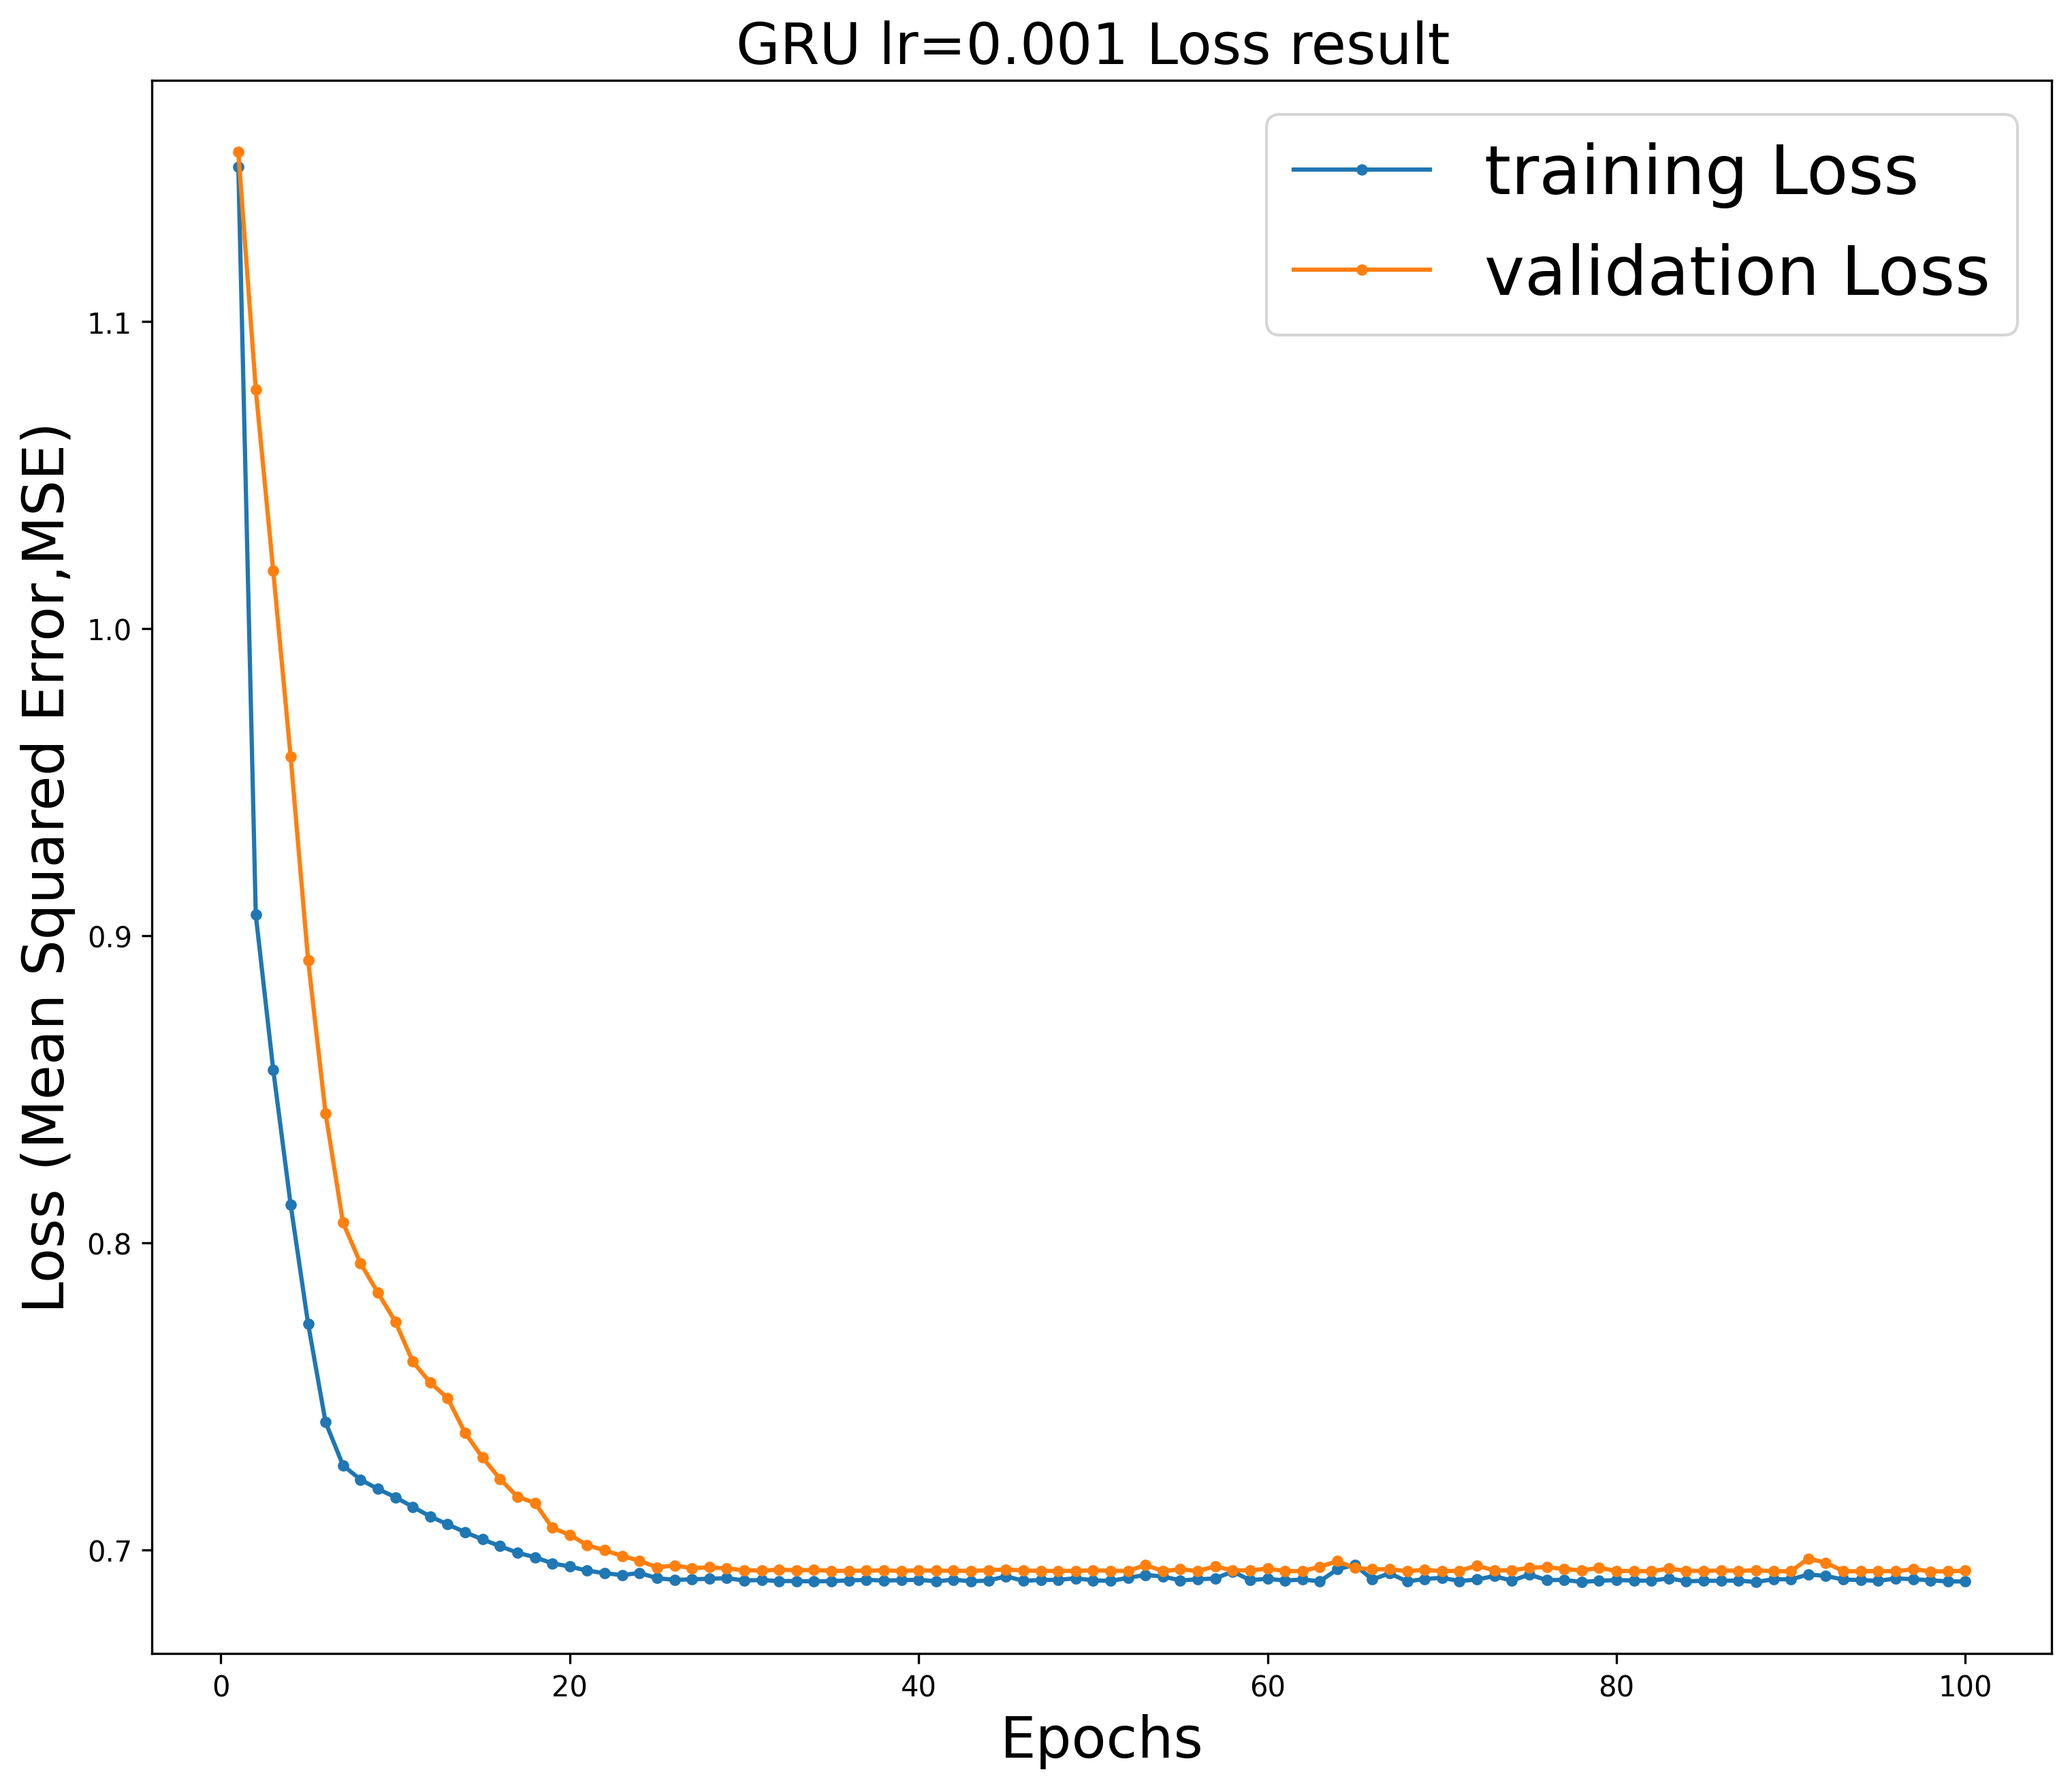

In [ ]:
#Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Mean Squared Error,MSE)',fontsize=20)
plt.title('GRU lr=0.001 Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

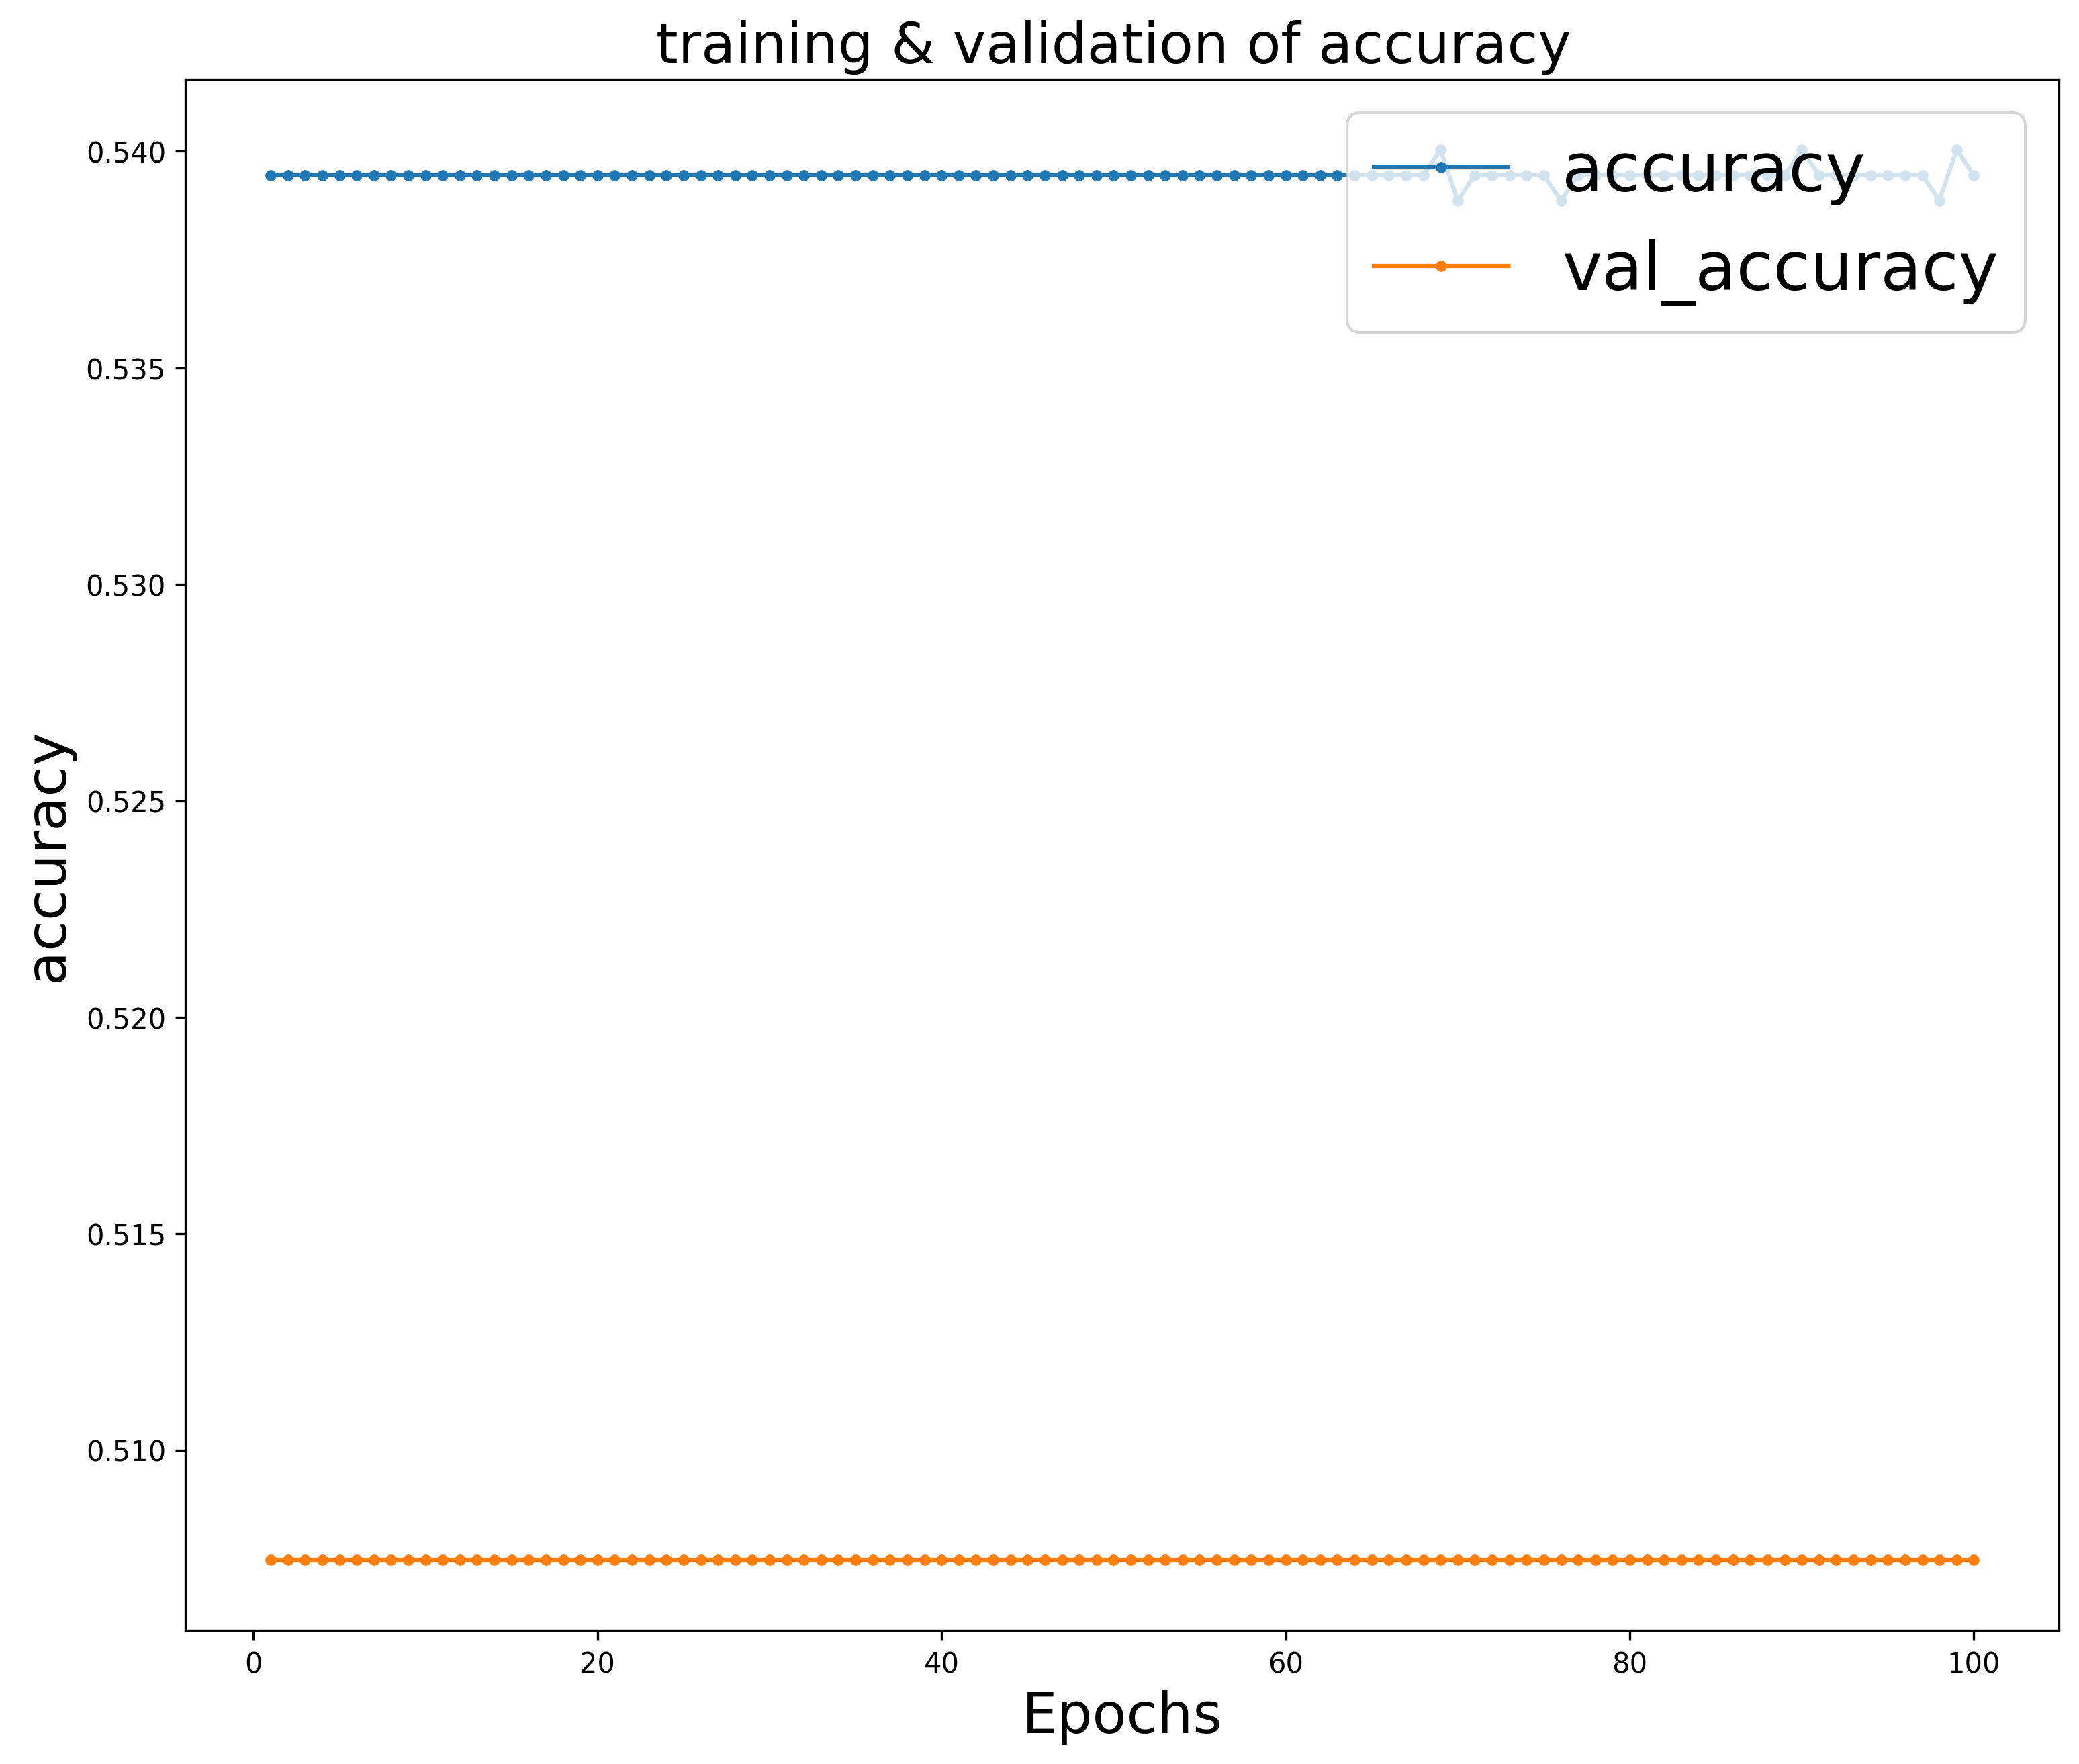

In [ ]:
# 7.2 Plot the history of training and validation
training_acc_values=modeling_result['accuracy']
val_acc_values=modeling_result['val_accuracy']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('accuracy',fontsize=20)
plt.title('training & validation of accuracy ',fontsize=20)

plt.plot(epochs, training_acc_values,marker='.',label='accuracy')
plt.plot(epochs, val_acc_values,marker='.',label='val_accuracy')
plt.legend(loc=1,fontsize=24)
plt.show()

In [ ]:
# 在測試集上進行預測
predicted_labels = model.predict(X_test)
predicted_labels = np.where(predicted_labels > 0.5, 1, 0)

# 計算準確率
accuracy = np.mean(predicted_labels == y_test)
print('Accuracy:', accuracy)


17/17 [==============================] - 0s 2ms/step
Accuracy: 0.5375939849624061
